### 1. Ariticle and Population data

The datasets used in this assignment were provided at the following locations: <br/>
This code assumes that these files are pre-downloaded into the 'data-raw' folder. <br/>

article data: https://figshare.com/articles/Untitled_Item/5513449 <br/>
population data: https://www.dropbox.com/s/5u7sy1xt7g0oi2c/WPDS_2018_data.csv?dl=0 <br/>

The article data contains the list of wikipedia articles, their country, and the revision <br/>
id. The population data contains the populations of a list of geographical regions.

In [5]:
import pandas  as pd

data_raw_path = './data-raw'

page_data = pd.read_csv(f'{data_raw_path}/page_data.csv')
wpds_data = pd.read_csv(f'{data_raw_path}/WPDS_2018_data.csv')

display(page_data.head())
display(wpds_data.head())

,page,country,rev_id
0,Template:ZambiaProvincialMinisters,Zambia,235107991
1,Bir I of Kanem,Chad,355319463
2,Template:Zimbabwe-politician-stub,Zimbabwe,391862046
3,Template:Uganda-politician-stub,Uganda,391862070
4,Template:Namibia-politician-stub,Namibia,391862409


,Geography,Population mid-2018 (millions)
0,AFRICA,"1,284"
1,Algeria,42.7
2,Egypt,97
3,Libya,6.5
4,Morocco,35.2


### Joining the datasets

The two pandas dataframes have country/geography in common (although not <br>
exactly in the same format). It is not clear if they have the same set of values.

In [36]:
set_page = set(page_data.country)
set_wpds = set(wpds_data.Geography)

print('regions only in article data:', len(set_page - set_wpds))
print('regions only in population data:', len(set_wpds - set_page))
print('regions in both:', len(set_page.intersection(set_wpds)))

regions only in article data: 39
regions only in population data: 27
regions in both: 180


This shows that both page data and population data have places that do not show <br>
in the other dataset. Also, The population column is formatted as a string, with <br>
some values being ',' separated. 

In [155]:
df = pd.merge(page_data, wpds_data, left_on='country', right_on='Geography', how='inner')
df = df.rename({'Population mid-2018 (millions)': 'population'}, axis=1)
df.population = df.population.str.replace(',', '').astype(float)
df = df.drop('Geography', axis=1)

df.head()

,page,country,rev_id,population
0,Template:ZambiaProvincialMinisters,Zambia,235107991,17.7
1,Gladys Lundwe,Zambia,757566606,17.7
2,Mwamba Luchembe,Zambia,764848643,17.7
3,Thandiwe Banda,Zambia,768166426,17.7
4,Sylvester Chisembele,Zambia,776082926,17.7


### Adding ORES scores to the dataframe

In this step, we call the wikipedia Objective Revision Evaluation Service API <br>
for all the aritcles in the dataframe/

Some of the code used in this block is borrowed from the example code provided in the <br>
in the template repository for this assignment (https://github.com/Ironholds/data-512-a2)

In [130]:
import requests

endpoint = 'https://ores.wikimedia.org/v3/scores/{project}/?models={model}&revids={revids}'
headers = {
    'user-agent' : 'https://github.com/viv-r', 
    'from' : 'viv-r@uw.edu'
}
params = {
    'project' : 'enwiki',
    'model'   : 'wp10',
}

def get_ores_data(revision_ids):
    params['revids'] = '|'.join(str(x) for x in revision_ids)
    api_call = requests.get(endpoint.format(**params))
    response = api_call.json()['enwiki']['scores']
    predictions = []
    for i in response:
        try: 
            predictions.append(response[i]['wp10']['score']['prediction'])
        except KeyError:
            predictions.append('Error')

    return predictions

We take 25 rows at a time from the data frame and construct a column with the scores <br>
from the above API

In [156]:
batch_size = 140

# df = df.sample(1000) # uncomment for testing, since this api takes a while

groups = df.set_index(df.index // batch_size).groupby(level=0)
predictions = sum(groups.apply(lambda x: get_ores_data(x.rev_id)).values.tolist(), [])
df['prediction'] =  predictions
df.head()

,page,country,rev_id,population,predictions
0,Template:ZambiaProvincialMinisters,Zambia,235107991,17.7,Error
1,Gladys Lundwe,Zambia,757566606,17.7,Stub
2,Mwamba Luchembe,Zambia,764848643,17.7,Stub
3,Thandiwe Banda,Zambia,768166426,17.7,Stub
4,Sylvester Chisembele,Zambia,776082926,17.7,Stub


In [166]:
df.to_csv('data-processed/dataset.csv')

### Analysis

Articles ranked GA or FA by the API above are categorized as high-quality. <br>
In this section, we create 4 tables showing the following information

2 tables showing the highest and lowest ranked regions interms of politician articles <br>
as a proportion of population

2 tables showing the highest and lowest ranked regions interms of proportions of high <br>
quality articles to the number of total articles.

In [215]:
df['good_quality'] = (df.prediction == 'GA') | (df.prediction == 'FA')
df['article_count'] = df.groupby('country').transform('count').page

summary = df.groupby('country').mean()
summary['ratio_article_to_pop'] = summary.article_count / summary.population
summary['ratio_quality_to_articles'] = 100 * summary.good_quality / summary.article_count

#### 10 lowest-ranked countries: Ratio of politician articles to country population

,ratio_article_to_pop
country,
India,0.721943
Indonesia,0.810709
China,0.816473
Uzbekistan,0.881459
Ethiopia,0.976744
Zambia,1.468927
"Korea, North",1.523437
Thailand,1.691843
Bangladesh,1.947115


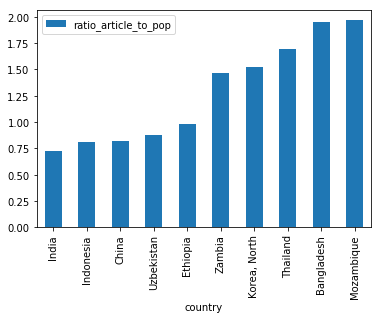

In [232]:
%matplotlib inline

table = summary[['ratio_article_to_pop']].sort_values('ratio_article_to_pop').head(10)
display(table); table.plot(kind='bar')

#### 10 highest-ranked countries: Ratio of politician articles to country population

,ratio_article_to_pop
country,
Tuvalu,5500.000000
Nauru,5300.000000
San Marino,2733.333333
Monaco,1000.000000
Liechtenstein,725.000000
Tonga,630.000000
Marshall Islands,616.666667
Iceland,515.000000
Andorra,425.000000


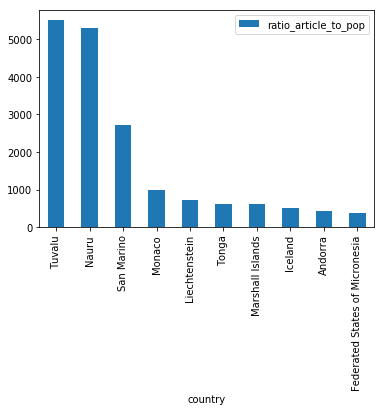

In [233]:
table = summary[['ratio_article_to_pop']].sort_values('ratio_article_to_pop', ascending=False).head(10)
display(table); table.plot(kind='bar')

#### 10 lowest-ranked countries: ratio of article quality to article count

In [236]:
table = summary[['ratio_quality_to_articles']].sort_values('ratio_quality_to_articles').head(10)
table

,ratio_quality_to_articles
country,
Zimbabwe,0.0
Central African Republic,0.0
Sao Tome and Principe,0.0
Comoros,0.0
Qatar,0.0
Kuwait,0.0
Dominica,0.0
Dominican Republic,0.0
Eritrea,0.0


#### 10 highest-ranked countries: ratio of article quality to article count

,ratio_quality_to_articles
country,
Belize,0.390625
Kosovo,0.303819
Equatorial Guinea,0.292969
Marshall Islands,0.292184
Bhutan,0.275482
Uzbekistan,0.237812
Bahrain,0.226757
Seychelles,0.206612
"Korea, North",0.197239


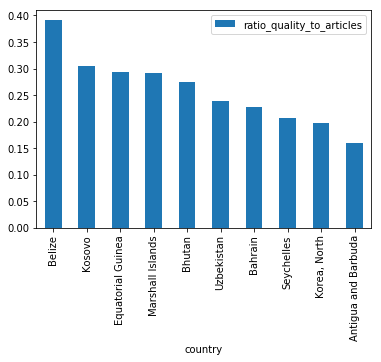

In [237]:
table = summary[['ratio_quality_to_articles']].sort_values('ratio_quality_to_articles', ascending=False).head(10)
display(table); table.plot(kind='bar')